## 用逻辑回归对坦坦尼克号数据进行分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')    # 设置seaborn画图的背景为白色
sns.set(style='whitegrid', color_codes=True)
import os
os.chdir('E:\python\实战\机器学习实战\Cp5_logisticRegresson')
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### 1、读取数据

In [2]:
df = pd.read_csv('./data/titanic_data.csv')
print('数据量为：{}'.format(df.shape[0]))

数据量为：1310


### 2、初步查看数据的缺失值情况,并处理缺失数据

In [3]:
print('查看数据的缺失值情况:\n', df.isnull().sum())

查看数据的缺失值情况:
 pclass         1
survived       1
name           1
sex            1
age          264
sibsp          1
parch          1
ticket         1
fare           2
cabin       1015
embarked       3
dtype: int64


#### 2.1 age的缺失值情况

age的缺失数据所占的百分比为：20.15%


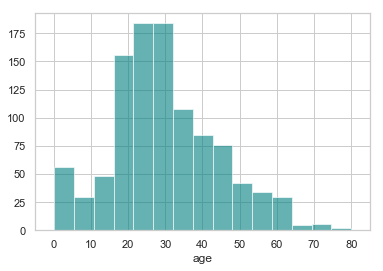

age's mean value is 29.88
age's median value is 28.00


In [4]:
### 先查看缺失数据所占的百分比
print('age的缺失数据所占的百分比为：%.2f%%'%(df['age'].isnull().sum()/df.shape[0]*100))
### 再绘制直方图看一看年龄的分布情况
ax = df['age'].hist(bins=15, color='teal', alpha=0.6)
ax.set(xlabel='age')
plt.xlim([-5, 85])
plt.show()
#### 图像为右偏分布，所以使用均值代替缺失值不是最佳选择，可以考虑采用中位数来代替缺失值
print("age's mean value is %0.2f"%(df['age'].mean(skipna=True)))    # 29.88
print("age's median value is %0.2f"%(df['age'].median(skipna=True)))    # 28.00

#### 2.2cabin(仓位)的缺失值情况

In [5]:
print('cabin的缺失值占比为：%.2f%%'%(df['cabin'].isnull().sum()/df.shape[0]*100))
### 因为'cabin'这一列缺失值高达77.48%，所以将这一列舍弃

cabin的缺失值占比为：77.48%


#### 2.3embarked(登船地点)的缺失值情况

embarked的缺失值占比为：0.23%
embarked的值的类型:
 S    914
C    270
Q    123
Name: embarked, dtype: int64


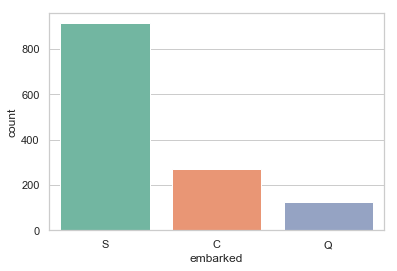

In [6]:
print('embarked的缺失值占比为：%.2f%%'%(df['embarked'].isnull().sum()/df.shape[0]*100))
print('embarked的值的类型:\n', df['embarked'].value_counts())
### 绘制计数直方图
sns.countplot(x='embarked', data=df, palette='Set2')
plt.show()
### embarked的缺失值占比为0.23%，且S类的占比最高，所以以S填充缺失值

#### 2.4根据缺失值的不同程度进行缺失值处理

此时数据的缺失情况为：
 pclass      1
survived    1
name        1
sex         1
age         0
sibsp       1
parch       1
ticket      1
fare        2
embarked    0
dtype: int64


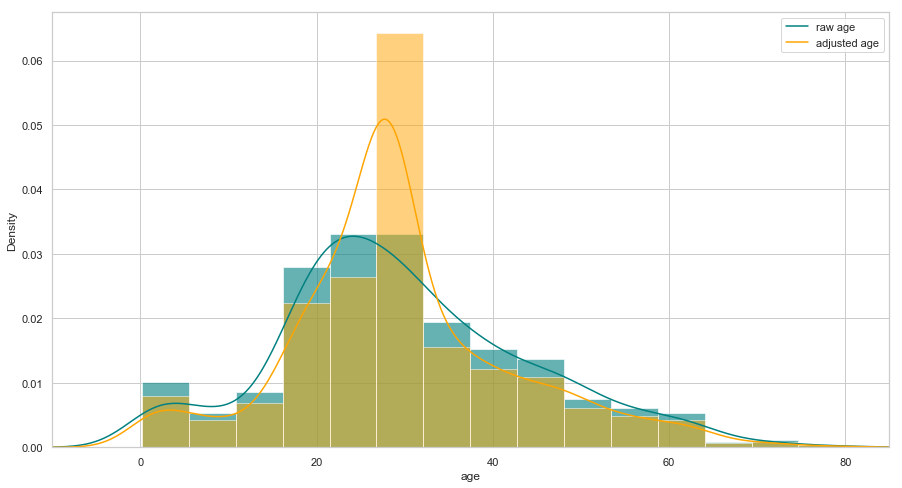

In [7]:
data = df.copy()
data['age'].fillna(df['age'].median(skipna=True), inplace=True)
data.drop('cabin', axis=1, inplace=True)
data['embarked'].fillna(df['embarked'].value_counts().idxmax(), inplace=True)
print('此时数据的缺失情况为：\n', data.isnull().sum())
### 查看年龄调整后的分布
plt.figure(figsize=(15, 8))
ax = df['age'].hist(bins=15, normed=True, stacked=True, color='teal', alpha=0.6)
df['age'].plot(kind='density', color='teal')
ax = data['age'].hist(bins=15, normed=True, stacked=True, color='orange', alpha=0.5)
data['age'].plot(kind='density', color='orange')
ax.legend(['raw age', 'adjusted age'])
ax.set(xlabel='age')
plt.xlim([-10, 85])
plt.show()
### 通过以上的处理，数据中仍然存在缺失值数据

### 3、其余特征的处理

#### 3.1 数据中的两个特征'sibsp'(一同登船的兄弟姐妹或配偶数量)、'parch'(一同登船的父母或子女数量)，为了防止这两个特征出现多重共线性，将这两个变量转变为一个变量TravelAlone(是否独自一人出行)

In [8]:
data['TravelAlone'] = np.where((data['sibsp']+data['parch'])>0, 0, 1)    # 【特征工程之特征构造】
data.drop(['sibsp', 'parch'], axis=1, inplace=True)

#### 3.2对embarked、sex进行独热编码，丢弃name、ticket

In [9]:
final = pd.get_dummies(data, columns=['embarked', 'sex'])
final.drop(['name', 'ticket'], axis=1, inplace=True)

#### 3.3由于其他的缺失值数量较少，所以直接舍弃

In [10]:
final.dropna(inplace=True)

In [11]:
final.head()

,pclass,survived,age,fare,TravelAlone,embarked_C,embarked_Q,embarked_S,sex_female,sex_male
0,1.0,1.0,29.0000,211.3375,1,0,0,1,1,0
1,1.0,1.0,0.9167,151.5500,0,0,0,1,0,1
2,1.0,0.0,2.0000,151.5500,0,0,0,1,1,0
3,1.0,0.0,30.0000,151.5500,0,0,0,1,0,1
4,1.0,0.0,25.0000,151.5500,0,0,0,1,1,0


### 4、特征工程之特征选择

#### 4.1绘制age、fare的核密度图

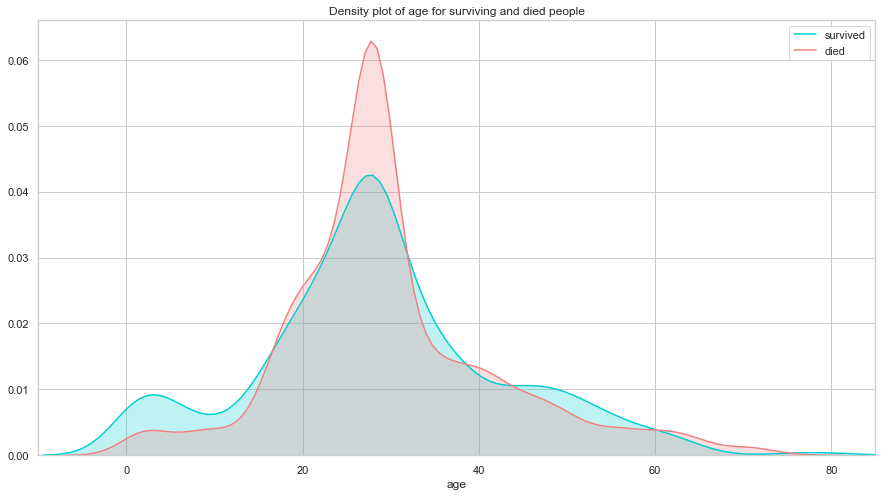

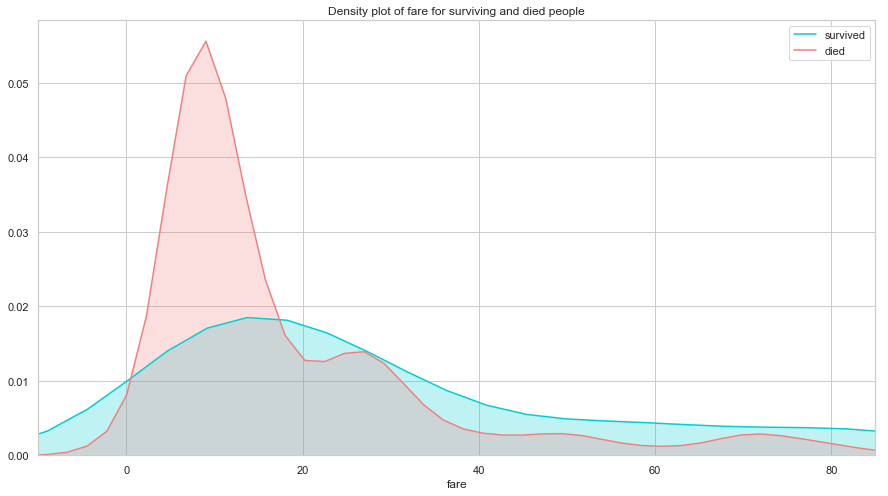

In [12]:
# age
plt.figure(figsize=(15, 8))
ax = sns.kdeplot(final['age'][final['survived']==1], color='darkturquoise', shade=True)
sns.kdeplot(final['age'][final['survived']==0], color='lightcoral', shade=True)
plt.legend(['survived', 'died'])
plt.title('Density plot of age for surviving and died people')
plt.xlabel('age')
plt.xlim([-10,85])
plt.show()
## 发现生还和死亡者的密度分布大致相似，唯一最大的区别是在生还者中存在大量的低龄乘客，说明当时预先保留了孩子的生还机会

# fare
plt.figure(figsize=(15, 8))
ax = sns.kdeplot(final['fare'][final['survived']==1], color='darkturquoise', shade=True)
sns.kdeplot(final['fare'][final['survived']==0], color='lightcoral', shade=True)
plt.legend(['survived', 'died'])
plt.xlabel('fare')
plt.title('Density plot of fare for surviving and died people')
plt.xlim([-10,85])
plt.show()
## 生还与死亡者的票价分布差异较大，说明这个特征对预测乘客是否生还非常重要，票价又与仓位有关，所以接下来分析仓位

#### 4.2 对离散变量进行分析, 绘制条形图或堆叠图

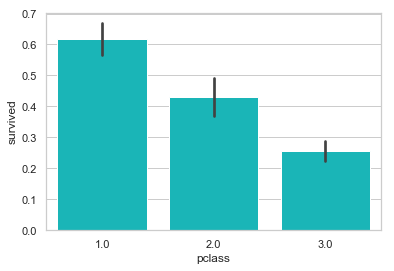

"\ntable = pd.crosstab(df.pclass, df.survived)\ntable.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)\nplt.show()\n"

In [13]:
# 仓位pclass
sns.barplot('pclass', 'survived', data=df, color='darkturquoise')
plt.show()
## 一等舱乘客的生还率最高

## 绘制堆叠图
'''
table = pd.crosstab(df.pclass, df.survived)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.show()
'''

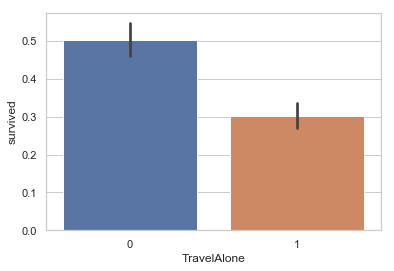

In [14]:
### TravelAlone
sns.barplot('TravelAlone', 'survived', data=final)
plt.show()

可以看出，独自出行的乘客的生还率比较低，在当时那个年代，独自出行的大多为男性

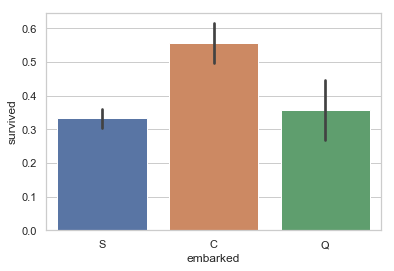

In [15]:
### embarked
sns.barplot('embarked', 'survived', data=df)
plt.show()

可以看出，从法国C登录的乘客的生还率最高

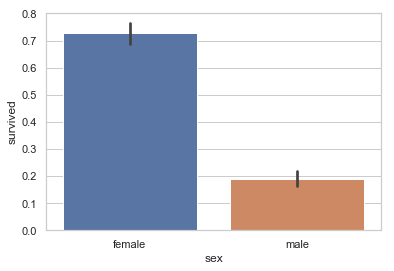

In [16]:
### sex
sns.barplot('sex', 'survived', data=df)
plt.show()

可以看出，女性的生还率明显高于男性

### 5、建立模型

In [17]:
x = final.loc[:, final.columns!='survived']
y = final['survived']
x_train, x_test, y_train, y_test = train_test_split(x, y)

clf = LogisticRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('accuracy acore is %.2f%%'%(accuracy_score(y_test, y_pred)*100))

accuracy acore is 78.59%
